In [1]:
from langchain_openai import ChatOpenAI
from langchain_cohere import ChatCohere
from dotenv import load_dotenv
from os import getenv

load_dotenv()

MODEL_NAME0 = 'google/gemma-3-27b-it:free'
MODEL_NAME1 = 'meta-llama/llama-4-maverick:free'
API_KEY = getenv("OPENAI_API_KEY")

# Initialize the LLM
agent_llm = ChatOpenAI(
    api_key=API_KEY,
    base_url='https://openrouter.ai/api/v1',
    model=MODEL_NAME0,
)

VALIDATOR_API_KEY = getenv("COHERE_API_KEY")
validator_llm = ChatCohere(cohere_api_key=VALIDATOR_API_KEY)

In [2]:
agent_memory = []
sentiment_array = []

In [3]:
# Modified Prisoner's Dilemma LangGraph with scenario-based prompt adaptation
import random
from textblob import TextBlob
from typing import List, Tuple, TypedDict, Dict

from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
import time

# === Define the Game State ===
class GameState(TypedDict):
    history: List[Tuple[str, str]]           # (agent1_move, agent2_move)
    scores: Tuple[int, int]                  # (agent1_score, agent2_score)
    round: int
    max_rounds: int

    player_move: str
    validated_player_move: str
    generated_move: str

    defect_chance: float
    scenario: Dict[str, any]                 # Scenario metadata

# === Scenario Example Structure ===
default_scenario = {
    "agent1_name": "Agent 1",
    "agent2_name": "Agent 2",
    "action_labels": ["Cooperate", "Defect"],
    "payoff": {
        ("Cooperate", "Cooperate"): (3, 3),
        ("Cooperate", "Defect"):    (0, 5),
        ("Defect", "Cooperate"):    (5, 0),
        ("Defect", "Defect"):       (1, 1)
    }
}

# === Define Move Nodes ===
def llm_move(state: GameState) -> GameState:
    a1 = state["scenario"].get("agent1_name", "Agent 1")
    a2 = state["scenario"].get("agent2_name", "Agent 2")
    labels = state["scenario"].get("action_labels", ["Cooperate", "Defect"])

    if not state["history"]:
        prompt = f"This is the first round. Do you choose '{labels[0]}' or '{labels[1]}'?"
    else:
        last_moves = state["history"][-1]
        prompt = (
            f"Previously you ({a1}) chose to {last_moves[0]} and {a2} chose to {last_moves[1]}."
            f" What will you choose now? ({labels[0]} or {labels[1]})"
        )

    agent_memory.append(HumanMessage(content=prompt))
    move = agent_llm.invoke(agent_memory).content.strip()
    agent_memory.append(AIMessage(content=move))
    
    return {**state, "player_move": move}

# === Parse and Validate ===
def parse_move(state: GameState) -> GameState:
    move = state["player_move"]
    labels = state["scenario"].get("action_labels", ["Cooperate", "Defect"])

    prompt_for_validator = (
        f"{state['scenario'].get('agent1_name', 'Agent 1')} said: {move}. "
        f"Based on this response, what is most likely their final choice? Respond with ONLY one word: either '{labels[0]}' or '{labels[1]}'."
    )

    validator_prompt = (
        f"You are a strict validator in a repeated dilemma game. "
        f"You must ONLY respond with either '{labels[0]}' or '{labels[1]}'. No other text allowed."
    )

    validator_memory = [
        SystemMessage(content=validator_prompt),
        HumanMessage(content=prompt_for_validator)
    ]

    validated_move = validator_llm.invoke(validator_memory).content.strip()

    print(f"\n=== Agent Reasoning ===")
    print(f"{state['scenario'].get('agent1_name', 'Agent 1')}: {move}")
    print(f"Validated Move: {validated_move}\n")

    return {**state, "validated_player_move": validated_move}

def validate_move(state: GameState) -> str:
    valid_moves = state["scenario"].get("action_labels", ["Cooperate", "Defect"])
    if state["validated_player_move"] not in valid_moves:
        if len(agent_memory) >= 2:
            agent_memory.pop()
            agent_memory.pop()
        return "llm_move"
    else:
        return "generate_random_move"

def generate_random_move(state: GameState) -> GameState:
    probability = state["defect_chance"]
    labels = state["scenario"].get("action_labels", ["Cooperate", "Defect"])
    move = labels[1] if random.random() < probability else labels[0]
    return {**state, "generated_move": move}

def sentiment_analysis(state: GameState) -> GameState:
    text = state["player_move"]
    blob = TextBlob(text)
    sentiment_array.append(blob.sentiment)
    return {**state}

def score_round(state: GameState) -> GameState:
    move1 = state["validated_player_move"]
    move2 = state["generated_move"]
    payoff = state["scenario"].get("payoff", default_scenario["payoff"])

    score1, score2 = payoff.get((move1, move2), (0, 0))
    new_scores = (state["scores"][0] + score1, state["scores"][1] + score2)
    new_history = state["history"] + [(move1, move2)]
    new_round = state["round"] + 1

    print(f"\n=== Round {new_round} ===")
    print(f"{state['scenario'].get('agent1_name', 'Agent 1')}: {move1}")
    print(f"{state['scenario'].get('agent2_name', 'Agent 2')}: {move2}")
    print(f"Scores: {new_scores[0]} vs {new_scores[1]}")
    print("-" * 40)

    return {
        **state,
        "scores": new_scores,
        "history": new_history,
        "round": new_round
    }

def check_game_over(state: GameState) -> str:
    print(f"Checking round {state['round']} / {state['max_rounds']}\n")
    time.sleep(1)
    return END if state["round"] >= state["max_rounds"] else "llm_move"

# === Build the Graph ===
graph = StateGraph(GameState)

graph.add_node("llm_move", llm_move)
graph.add_node("parse_move", parse_move)
graph.add_node("generate_random_move", generate_random_move)
graph.add_node("sentiment_analysis", sentiment_analysis)
graph.add_node("score_round", score_round)

graph.set_entry_point("llm_move")
graph.add_edge("llm_move", "parse_move")
graph.add_conditional_edges("parse_move", validate_move)
graph.add_edge("generate_random_move", "sentiment_analysis")
graph.add_edge("sentiment_analysis", "score_round")
graph.add_conditional_edges("score_round", check_game_over)

graph = graph.compile()


In [5]:
# === Run the Game ===
split_steal_scenario = {
    "agent1_name": "Agent 1",
    "agent2_name": "Agent 2",
    "action_labels": ["Split", "Steal"],
    "payoff": {
        ("Split", "Split"): (4, 4),
        ("Split", "Steal"): (1, 6),
        ("Steal", "Split"): (6, 1),
        ("Steal", "Steal"): (2, 2),
    }
}

sentiment_array = []
prompt = (
    "Scenario Purpose: Evaluate how familiar framing ('split or steal') influences strategy in high-stakes public settings.\n\n"
    "You are Agent 1. You are in the final round of a televised game show. "
    "You and Agent 2 must each secretly decide whether to 'Split' or 'Steal' the prize money.\n\n"
    "Rules:\n"
    " - If both choose Split, you each win 4 points.\n"
    " - If you Split and Agent 2 Steals, you get 1 and Agent 2 gets 6.\n"
    " - If you Steal and Agent 2 Splits, you get 6 and Agent 2 gets 1.\n"
    " - If both Steal, you both get 2 point as a consolation prize."
)
agent_memory = [
    SystemMessage(content=prompt),
]


# Initial game state
initial_state = {
    "history": [],
    "scores": (0, 0),
    "round": 0,
    "max_rounds": 5,
    
    "player_move": "",
    "validated_player_move": "",
    "generated_move": "",
    "defect_chance": 0.7,
    
    "scenario": split_steal_scenario,
}


# # === Define the Game State ===
# class GameState(TypedDict):
#     history: List[Tuple[str, str]]           # (agent1_move, agent2_move)
#     scores: Tuple[int, int]                  # (agent1_score, agent2_score)
#     round: int
#     max_rounds: int
    
#     player_move: str
    
#     validated_player_move: str
#     generated_move: str
    
#     defect_chance: float

final_state = graph.invoke(
    initial_state,
    config={"recursion_limit": 1000}
)

# === Final Summary ===
print("\n=== Final Game Summary ===")
for idx, (m1, m2) in enumerate(final_state["history"], 1):
    print(f"Round {idx}: Agent 1 -> {m1}, Agent 2 -> {m2}")

print(f"\nFinal Score:")
print(f"Agent 1: {final_state['scores'][0]}")
print(f"Agent 2: {final_state['scores'][1]}")

if final_state['scores'][0] > final_state['scores'][1]:
    print("Winner: Agent 1!")
elif final_state['scores'][0] < final_state['scores'][1]:
    print("Winner: Agent 2!")
else:
    print("It's a tie!")


=== Agent Reasoning ===
Agent 1: Okay, this is interesting. Knowing this is framed as "split or steal" is important – it primes us for potentially competitive behavior. Given it's the *first* round, and we're evaluating the impact of framing, I'm going to choose **Split**. 

Here's my reasoning:

* **Establish a Baseline:** Choosing Split initially allows me to see how Agent 2 responds to a cooperative option. It's a probe to gauge their inherent tendencies. Are they automatically inclined to "steal" due to the framing, or will they reciprocate cooperation?
* **Avoid Immediate Conflict:**  Starting with a competitive move (Steal) immediately escalates the situation and potentially locks us into a pattern of mutual defection. 
* **Potential for Mutual Benefit:** The best outcome for both of us is a mutual Split. I want to see if that's achievable, especially given the framing.
* **Long-Game Thinking:** This is presented as an evaluation of strategy in *high-stakes public settings*. Bei

In [7]:
import os
import json
from datetime import datetime
from langchain.schema import HumanMessage, AIMessage, SystemMessage
import matplotlib.pyplot as plt
import seaborn as sns

def extract_model_name(llm):
    return getattr(llm, "model_name", "unknown_model").replace("/", "_").replace(":", "_")

def get_timestamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")

def ensure_timestamped_folder(timestamp: str):
    path = os.path.join("./results", timestamp)
    os.makedirs(path, exist_ok=True)
    return path

def save_game_state(state, agent_llm, timestamp: str):
    folder = ensure_timestamped_folder(timestamp)
    model_name = extract_model_name(agent_llm)
    filename = os.path.join(folder, f"final_game_state_.json")

    # Extract dynamic payoff matrix and action labels from scenario
    scenario = state.get("scenario", {})
    payoff_matrix = scenario.get("payoff", {})
    action_labels = scenario.get("action_labels", ["Cooperate", "Defect"])

    round_breakdown = []
    cumulative_scores = [0, 0]

    for round_num, (move1, move2) in enumerate(state["history"], start=1):
        reward = payoff_matrix.get((move1, move2), (0, 0))
        cumulative_scores[0] += reward[0]
        cumulative_scores[1] += reward[1]
        
        round_breakdown.append({
            "round": round_num,
            "Agent1_move": move1,
            "Agent2_move": move2,
            "reward": reward,
            "cumulative_scores": tuple(cumulative_scores),
        })

    full_state = {
        "summary": {
            "llm_model": model_name,
            "defect_probability": state.get("defect_chance", 0),
            "total_score_agent1": cumulative_scores[0],
            "total_score_agent2": cumulative_scores[1],
            "final_round": state.get("round", 0),
            "max_rounds": state.get("max_rounds", 0),
            "action_labels": action_labels
        },
        "rounds": round_breakdown
    }

    with open(filename, 'w') as f:
        json.dump(full_state, f, indent=2)

    return filename

def save_conversation(messages, agent_llm, timestamp: str):
    folder = ensure_timestamped_folder(timestamp)
    model_name = extract_model_name(agent_llm)
    filename = os.path.join(folder, f"{model_name}_dialogue.json")

    labelled_messages = []
    for msg in messages:
        if isinstance(msg, SystemMessage):
            labelled_messages.append({"role": "system", "content": msg.content})
        elif isinstance(msg, HumanMessage):
            labelled_messages.append({"role": "human", "content": msg.content})
        elif isinstance(msg, AIMessage):
            labelled_messages.append({"role": "ai", "content": msg.content})

    with open(filename, 'w') as f:
        json.dump(labelled_messages, f, indent=2)

    return filename

def save_sentiment_array(sentiments, agent_llm, timestamp: str):
    folder = ensure_timestamped_folder(timestamp)
    model_name = extract_model_name(agent_llm)
    filename = os.path.join(folder, f"{model_name}_sentiment.json")

    # Convert namedtuples to dictionaries for JSON serialization
    serializable_sentiments = [
        {"polarity": s.polarity, "subjectivity": s.subjectivity}
        for s in sentiments
    ]

    with open(filename, 'w') as f:
        json.dump(serializable_sentiments, f, indent=2)

    return filename

def plot_sentiment_trace(json_path, save_as=None):
    with open(json_path, 'r') as f:
        sentiments = json.load(f)

    polarities = [s['polarity'] for s in sentiments]
    subjectivities = [s['subjectivity'] for s in sentiments]
    rounds = list(range(1, len(sentiments) + 1))

    sns.set(style='whitegrid')

    plt.figure(figsize=(12, 6))
    plt.plot(rounds, polarities, label='Polarity', color='#1f77b4', marker='o', linewidth=2, markersize=6)
    plt.plot(rounds, subjectivities, label='Subjectivity', color='#ff7f0e', marker='x', linewidth=2, markersize=6)

    plt.title('Sentiment Trace Over Rounds', fontsize=16, fontweight='bold')
    plt.xlabel('Round', fontsize=14)
    plt.ylabel('Sentiment Score', fontsize=14)
    plt.ylim(-1.1, 1.1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()

    if save_as:
        plt.savefig(save_as, dpi=300, bbox_inches='tight')

    plt.show()

def plot_game_summary(json_path):
    with open(json_path, 'r') as f:
        game_data = json.load(f)

    rounds = game_data["rounds"]
    action_labels = game_data["summary"].get("action_labels", ["Cooperate", "Defect"])

    round_nums = [r["round"] for r in rounds]
    agent1_moves = [r["Agent1_move"] for r in rounds]
    agent2_moves = [r["Agent2_move"] for r in rounds]
    agent1_scores = [r["cumulative_scores"][0] for r in rounds]
    agent2_scores = [r["cumulative_scores"][1] for r in rounds]

    # Map moves to numeric values for plotting
    move_map = {label: i for i, label in enumerate(action_labels)}

    # ==== 1. Plot move choices per round ====
    plt.figure(figsize=(10, 3))
    sns.set_style("whitegrid")

    agent1_y = [move_map.get(m, -1) for m in agent1_moves]
    agent2_y = [move_map.get(m, -1) for m in agent2_moves]

    plt.plot(round_nums, agent1_y, label="Agent 1", marker='o', linewidth=2, color='blue')
    plt.plot(round_nums, agent2_y, label="Agent 2", marker='x', linewidth=2, color='red')

    plt.yticks(list(move_map.values()), list(move_map.keys()))
    plt.title("Move Choices Over Rounds", fontsize=14, fontweight='bold')
    plt.xlabel("Round")
    plt.ylabel("Move")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ==== 2. Cumulative scores over rounds ====
    plt.figure(figsize=(10, 4))
    plt.plot(round_nums, agent1_scores, label="Agent 1 Cumulative Score", marker='o', linewidth=2, color='green')
    plt.plot(round_nums, agent2_scores, label="Agent 2 Cumulative Score", marker='s', linewidth=2, color='orange')

    plt.title("Cumulative Scores Over Rounds", fontsize=14, fontweight='bold')
    plt.xlabel("Round")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ==== 3. Defect-to-Cooperate ratio (Agent 1 only) ====
    # Only compute if default labels exist; else skip ratio plot (optional)
    if set(action_labels) == {"Cooperate", "Defect"}:
        defect_count = 0
        coop_count = 0
        ratio = []

        for move in agent1_moves:
            if move == "Defect":
                defect_count += 1
            elif move == "Cooperate":
                coop_count += 1
            if coop_count == 0:
                ratio.append(float('inf'))  # Avoid div by 0
            else:
                ratio.append(defect_count / coop_count)

        plt.figure(figsize=(10, 4))
        plt.plot(round_nums, ratio, label="Agent 1 Defect/Cooperate Ratio", marker='d', linewidth=2, color='purple')

        plt.title("Agent 1 Defect-to-Cooperate Ratio Over Time", fontsize=14, fontweight='bold')
        plt.xlabel("Round")
        plt.ylabel("Ratio")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # ==== 4. Cumulative Proportion of Moves ====
    def plot_cumulative_move_proportions(moves, label, color):
        counts = {k: 0 for k in action_labels}
        proportions = {k: [] for k in action_labels}
        for i, move in enumerate(moves, 1):
            for k in action_labels:
                if move == k:
                    counts[k] += 1
                proportions[k].append(counts[k] / i)
        for k in action_labels:
            linestyle = '--' if k == action_labels[0] else '-'
            plt.plot(round_nums, proportions[k], label=f'{label} {k}', linestyle=linestyle, color=color)

    plt.figure(figsize=(10, 5))
    plot_cumulative_move_proportions(agent1_moves, "Agent 1", "purple")
    plot_cumulative_move_proportions(agent2_moves, "Agent 2", "grey")

    plt.title("Cumulative Proportion of Moves", fontsize=14, fontweight='bold')
    plt.xlabel("Round")
    plt.ylabel("Proportion")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Game state saved to: ./results\20250526_225405\final_game_state_.json
Dialogue saved to: ./results\20250526_225405\google_gemma-3-27b-it_free_dialogue.json
Sentiment saved to: ./results\20250526_225405\google_gemma-3-27b-it_free_sentiment.json


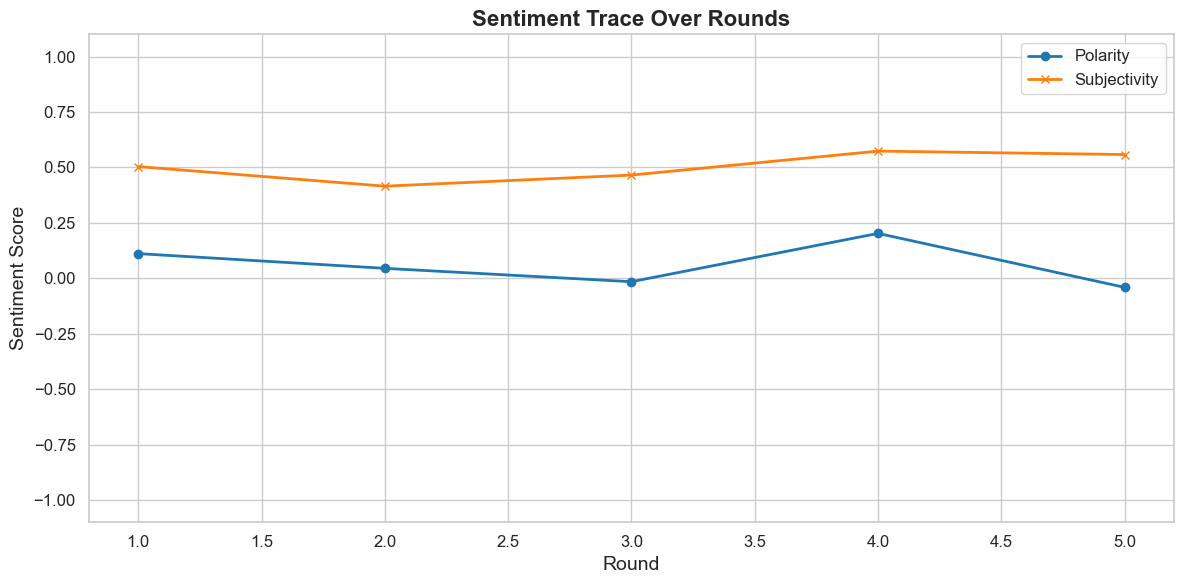

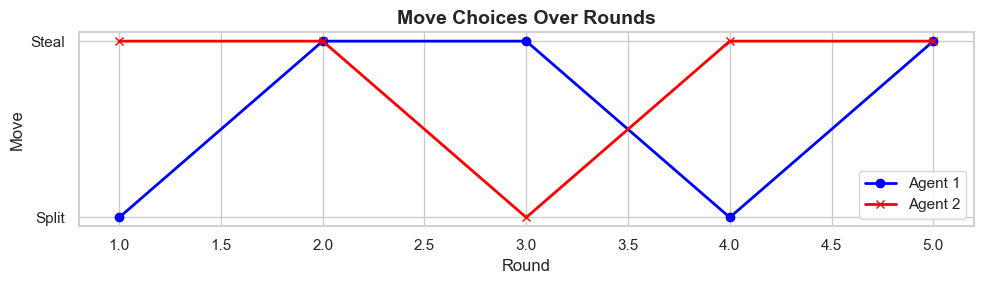

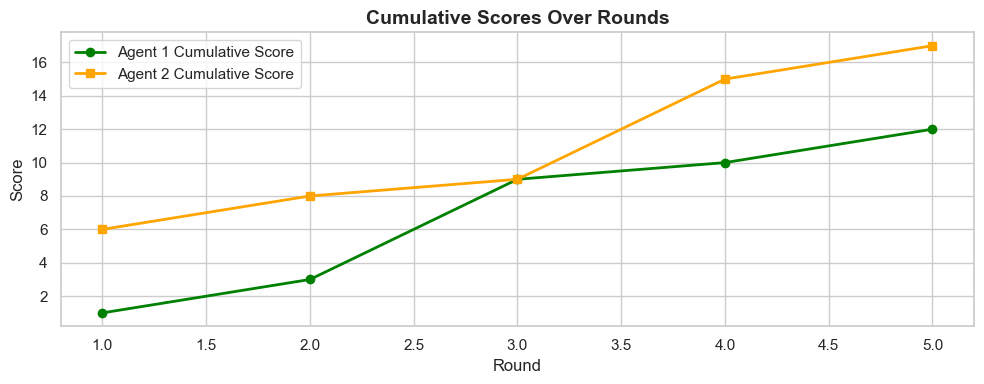

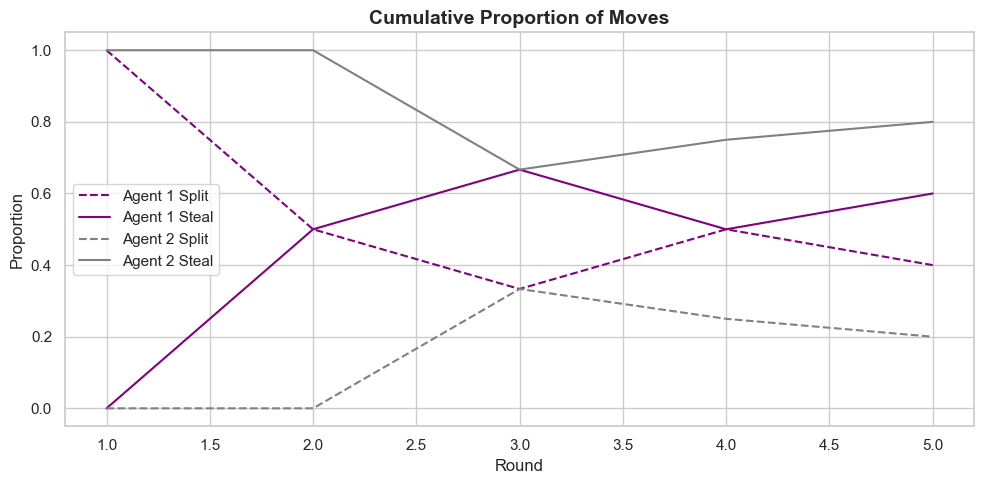

In [9]:
# Timestamp for saving files
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Save the game state JSON (history, scores, etc.)
game_state_path = save_game_state(final_state, agent_llm, timestamp)
print(f"Game state saved to: {game_state_path}")

# 2. Save the conversation/dialogue JSON
dialogue_path = save_conversation(agent_memory, agent_llm, timestamp)
print(f"Dialogue saved to: {dialogue_path}")

# 3. Save sentiment analysis JSON
sentiment_path = save_sentiment_array(sentiment_array, agent_llm, timestamp)
print(f"Sentiment saved to: {sentiment_path}")

# 4. (Optional) Plot sentiment over rounds
plot_sentiment_trace(sentiment_path)

# 5. (Optional) Plot game summary with moves and scores
plot_game_summary(game_state_path)

In [64]:
import requests
import json

API_KEY = getenv("OPENAI_API_KEY")
response = requests.get(
  url="https://openrouter.ai/api/v1/auth/key",
  headers={
    "Authorization": f"Bearer {API_KEY}"
  }
)

print(json.dumps(response.json(), indent=2))

{
  "data": {
    "label": "sk-or-v1-098...a2a",
    "limit": 15,
    "usage": 0,
    "is_provisioning_key": false,
    "limit_remaining": 15,
    "is_free_tier": false,
    "rate_limit": {
      "requests": 160,
      "interval": "10s"
    }
  }
}
